In [2]:
import numpy as np 
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as st 
from scipy.stats import norm
from scipy.stats import burr12
from scipy.fft import fft, ifft
import scipy.linalg as linalg
from scipy.optimize import minimize
import collections 
import time
from itertools import chain
import timeit
import os
import pickle

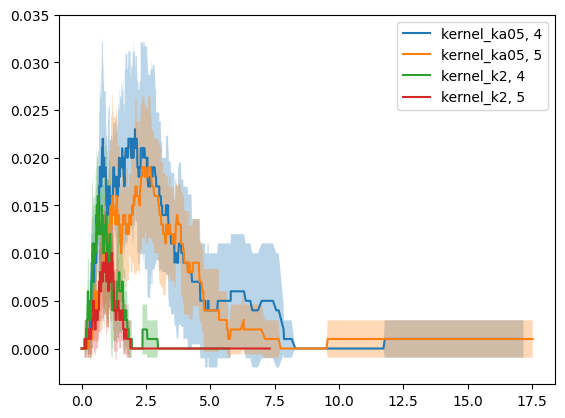

In [25]:
#load files
results_dir = "xEmilio" 
kernels = ["kernel_ka05", "kernel_k2"]
k_values = [4,5]  

# Initialize a dictionary to store the data
data = {kernel: {k: [] for k in k_values} for kernel in kernels}

# Load data from pickle files
def extract_parameters_from_filename(filename):
    parts = filename.replace('.pkl', '').split('_')
    N = int(parts[1][1:])  # Extract N value
    k = int(parts[2][1:])  # Extract k value
    kernel = '_'.join(parts[3:5])  # Reconstruct kernel name

    # Check for R value in the filename
    if len(parts) > 5:  # Filename contains R value
        R = int(parts[5][1:])
    else:  # Default R value
        R = 10
    return N, k, kernel, R

for filename in os.listdir(results_dir):
    if filename.endswith('.pkl'):
        N, k, kernel, R = extract_parameters_from_filename(filename)
        
        # Ensure kernel and k are within our specified ranges
        if kernel in kernels and k in k_values:
            filepath = os.path.join(results_dir, filename)
            with open(filepath, 'rb') as file:
                results = pickle.load(file)
                # Store results under the corresponding kernel and k
                data[kernel][k].append((N, R, results))

# Iterate over each kernel and k
for kernel in kernels:
    for k in k_values:
        for N, R, results in data[kernel][k]:
            # Load the means and sigma
            correct_denominator = np.sqrt(R)
            means = np.array(results["means"])
            sigma = np.array(results["sigma"])

            # Recalculate the correct confidence intervals
            c_ok = st.norm.ppf(1 - 0.05 / 2)  
            correct_lower_bound = means - (c_ok * sigma) / correct_denominator
            correct_upper_bound = means + (c_ok * sigma) / correct_denominator

            # Replace the incorrect bounds in the data dictionary
            results["lower_bound"] = correct_lower_bound
            results["upper_bound"] = correct_upper_bound
            plt.plot(results["J_sorted"], results["means"], label=f'{kernel}, {k}')
            plt.fill_between(results["J_sorted"], results["lower_bound"], results["upper_bound"], alpha=0.3)
            plt.legend()

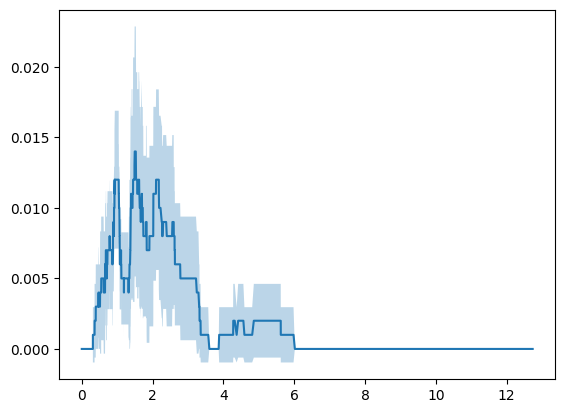

In [8]:
plt.plot(results["J_sorted"], results["means"], label=f'N = {N}')
plt.fill_between(results["J_sorted"], results["lower_bound"], results["upper_bound"], alpha=0.3)
        

NameError: name 'c' is not defined

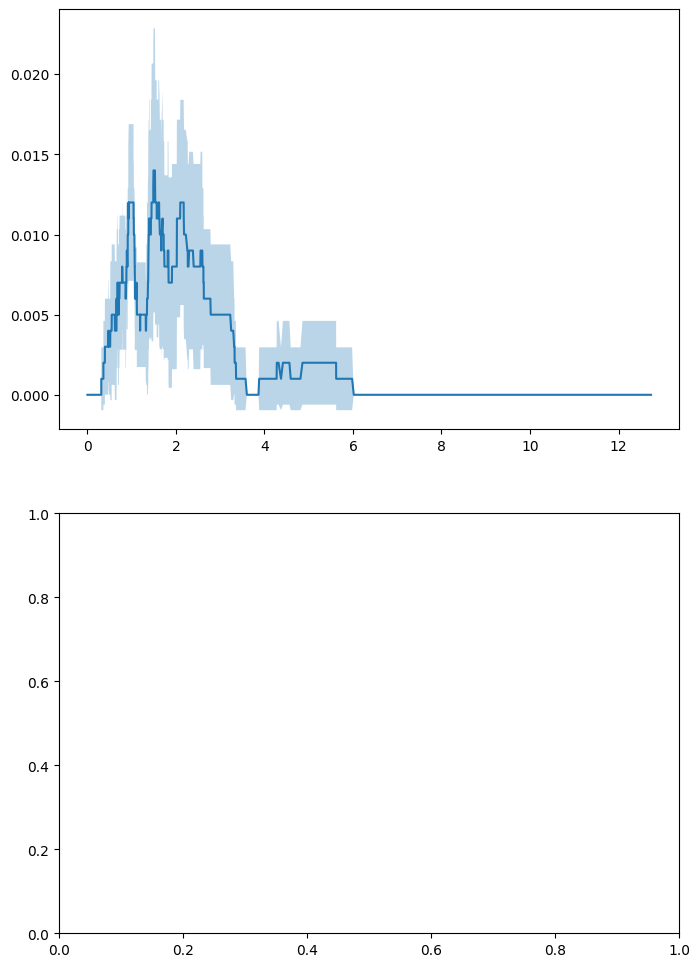

In [6]:
t_values = np.linspace(0, 10, 200)
N_list = [1000, 100]
fig, axs = plt.subplots(len(kernels), len(k_values), figsize=(8 * len(k_values), 6 * len(kernels)), squeeze=False)

for row_idx, kernel in enumerate(kernels):
    for col_idx, k in enumerate(k_values):
        ax = axs[row_idx, col_idx]

        # Plot each N value in the same subplot
        sorted_results = sorted(data[kernel][k], key=lambda x: x[0])
        for N, R, results in sorted_results:
            if N in N_list and R == 10:
                ax.plot(results["J_sorted"], results["means"], label=f'N = {N}')
                ax.fill_between(results["J_sorted"], results["lower_bound"], results["upper_bound"], alpha=0.3)
        
        # Plot theoretical curve only for the first row
        if row_idx == 0:
            c_values = [c(t, k) for t in t_values]
            ax.plot(t_values, c_values, label=f'Theoretical c(t,k) for k={k}', color='black', linewidth=3, linestyle = '--')

        ax.set_title(f'Kernel {kernel[-1]}, k = {k}')
        ax.set_xlabel('Time')
        ax.set_xlim(0, 10)
        if col_idx == 0:
            ax.set_ylabel('Average Concentration $c_n(k,t)$')
        ax.legend()

plt.tight_layout()
plt.show()